# GAN on CIFAR-10

# Setup imports and hyperparameters

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
from itertools import cycle
from tqdm import tqdm  # for displaying progress bar

In [ ]:
# Install extra package if FID is needed
!pip install pytorch-fid
from pytorch_fid import fid_score

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
# Hyperparameters from the table
z_dim = 100  # Size of the noise vector
lr = [0.0001, 0.0002, 0.0003]  # Learning rate for Adam optimizer
betas = (0.5, 0.999)  # Betas for Adam optimizer
batch_size = 100
image_size = 32
channels_img = 3
gen_features = 384  # Feature maps for the first layer of generator
disc_features = 16  # Feature maps for the first layer of discriminator
num_epochs = 100  # Assuming 50 for a shorter training time; can be changed to 50000 iterations
leaky_slope = 0.2  # Slope for the leaky ReLU
drop_out = 0.5  # Dropout rate
sigma_noise = 0.05  # Standard deviation for Gaussian noise
n_critic = 5  # Number of critic updates per generator update

# Define two DNNs

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_channels):
        super(Generator, self).__init__()

        # Define individual layers to access their output for printing
        self.init_linear = nn.Linear(z_dim, 384 * 4 * 4, bias=False)
        self.init_relu = nn.ReLU(True)

        self.conv_transpose1 = nn.ConvTranspose2d(384, 192, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(192)
        self.relu1 = nn.ReLU(True)

        self.conv_transpose2 = nn.ConvTranspose2d(192, 96, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(96)
        self.relu2 = nn.ReLU(True)

        self.conv_transpose3 = nn.ConvTranspose2d(96, img_channels, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False)
        self.tanh = nn.Tanh()

    def forward(self, noise):
        # Concatenate label embedding with noise
        gen_input = noise

        # Pass through initial linear layer and activation
        out = self.init_linear(gen_input)
        out = self.init_relu(out)
        out = out.view(out.size(0), 384, 4, 4)  # Reshape to (batch_size, 384, 4, 4)
        # print("After initial linear layer:", out.shape)

        # Pass through first transposed convolution layer
        out = self.conv_transpose1(out)
        out = self.bn1(out)
        out = self.relu1(out)
        # print("After first ConvTranspose2d:", out.shape)

        # Pass through second transposed convolution layer
        out = self.conv_transpose2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        # print("After second ConvTranspose2d:", out.shape)

        # Pass through third transposed convolution layer
        out = self.conv_transpose3(out)
        out = self.tanh(out)
        # print("After third ConvTranspose2d:", out.shape)

        return out

In [4]:
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float): Standard deviation of the Gaussian noise.
    """
    def __init__(self, sigma=0.05):
        super(GaussianNoise, self).__init__()
        self.sigma = sigma

    def forward(self, x):
        if self.training:
            noise = torch.randn_like(x) * self.sigma
            return x + noise
        return x

class Critic(nn.Module):
    def __init__(self, gaussian_noise, img_channels):
        super(Critic, self).__init__()
        self.noise = GaussianNoise(gaussian_noise)

        # Discriminator's Convolutional Layers with kernel size and stride as arguments
        self.main = nn.Sequential(
            # Input is 32 x 32 x img_channels
            nn.Conv2d(img_channels, 16, kernel_size=3, stride=2, padding=1, bias=False),
            nn.LeakyReLU(leaky_slope, inplace=True),
            nn.Dropout(drop_out),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),    # State size: 16 x 16 x 16
            nn.BatchNorm2d(32),
            nn.LeakyReLU(leaky_slope, inplace=True),
            nn.Dropout(drop_out),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),    # State size: 32 x 16 x 16
            nn.BatchNorm2d(64),
            nn.LeakyReLU(leaky_slope, inplace=True),
            nn.Dropout(drop_out),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),   # State size: 64 x 8 x 8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(leaky_slope, inplace=True),
            nn.Dropout(drop_out),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),  # State size: 128 x 8 x 8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(leaky_slope, inplace=True),
            nn.Dropout(drop_out),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False),  # State size: 256 x 4 x 4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(leaky_slope, inplace=True),
            nn.Dropout(drop_out),

            nn.Flatten()
        )

        # Output head for real/fake classification
        self.adv_layer = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img = self.noise(img)
        # Pass the input image through the feature extractor
        features = self.main(img)

        # Pass the features through the two heads
        real_fake = self.adv_layer(features)

        return real_fake

# Initialize models

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if 'Conv' in classname:
        torch.nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
    elif 'BatchNorm' in classname:
        torch.nn.init.normal_(m.weight.data, mean=1.0, std=0.02)
        torch.nn.init.constant_(m.bias.data, 0)
    elif "Linear" in classname:
        torch.nn.init.normal_(m.weight.data, mean=0.0, std=0.02)

In [6]:
# Transformations for the input data
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
])

# Load the CIFAR-10 dataset
full_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Split CIFAR-10 into training and testing sets
train_size = int(0.9 * len(full_dataset))  # 90% for training
validation_size = len(full_dataset) - train_size  # 10% for validation
train_dataset, validation_dataset = random_split(full_dataset, [train_size, validation_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

# Initialize Generator and Critic
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator(z_dim, channels_img).to(device)
critic = Critic(sigma_noise, channels_img).to(device)

# Load pre-trained models
'''
generator.load_state_dict(torch.load('/content/drive/MyDrive/ECE661/Project/WGAN/generator(3).pth'))
critic.load_state_dict(torch.load('/content/drive/MyDrive/ECE661/Project/WGAN/critic.pth'))
'''

# Initialize weights

generator.apply(weights_init)
critic.apply(weights_init)


# Binary Cross Entropy loss and auxiliary classification loss
adversarial_loss = nn.BCELoss().to(device)

# Setup Adam optimizers for both G and C
optimizer_G = optim.Adam(generator.parameters(), lr=lr[1], betas=betas)
optimizer_C = optim.Adam(critic.parameters(), lr=lr[1], betas=betas)

100%|██████████| 170498071/170498071 [00:10<00:00, 15594491.42it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Train GAN

In [7]:
# Record training process for later use
G_loss = []
C_loss = []
C_val_loss = []
G_grad = []
C_grad = []
FID = []

In [ ]:
# Change learning rate manually
optimizer_G = optim.Adam(generator.parameters(), lr=lr[0] / 2, betas=betas)
optimizer_C = optim.Adam(critic.parameters(), lr=lr[0] / 2, betas=betas)

In [8]:
# Initialize settings before start training
validation_iterator = cycle(validation_dataloader)
os.makedirs("generated_images", exist_ok=True)
os.makedirs("real_images", exist_ok=True)
real_images_path = "./real_images"
generated_images_path = "./generated_images"
real_imgs_save, labels = next(validation_iterator)
vutils.save_image(real_imgs_save[:min(batch_size, 100)], f"{real_images_path}/real_samples.png", normalize=True)
dynamic_lr = lr[1]

In [10]:
# Training loop
for epoch in range(num_epochs):
    # ------------------------------------------
    # Train the model
    # ------------------------------------------
    if epoch % 50 == 0 and epoch > 1:
        dynamic_lr = dynamic_lr * 0.7
        optimizer_G = optim.Adam(generator.parameters(), lr=dynamic_lr, betas=betas)
        optimizer_C = optim.Adam(critic.parameters(), lr=dynamic_lr, betas=betas)
        print(f"Learning rate changed to {dynamic_lr}")

    #loop = tqdm(dataloader, leave=True)
    #for batch_idx, (real, _) in enumerate(loop):
    G_loss_sum = 0
    C_loss_sum = 0
    G_grad_sum = 0
    C_grad_sum = 0
    num = 0
    for i, (imgs, labels) in enumerate(tqdm(train_dataloader)):

        # Configure input
        real_imgs = imgs.to(device)
        cur_batch_size = real_imgs.size(0)

        # Prepare labels for real and fake images
        real_validity = torch.ones(batch_size, 1, device=device)
        fake_validity = torch.zeros(batch_size, 1, device=device)

        #noise = torch.randn(cur_batch_size, z_dim).to(device)
        #noise = torch.clamp(noise, min=-1, max=1)
        #noise = torch.rand(cur_batch_size, z_dim).to(device)

        # -----------------
        # Train Critic
        # -----------------
        for _ in range(n_critic):
            z = torch.normal(0, 1.5, (batch_size, z_dim)).to(device)
            fake_imgs = generator(z)
            critic_real = critic(real_imgs)
            critic_fake = critic(fake_imgs)
            loss_critic = adversarial_loss(critic_real, real_validity) + adversarial_loss(critic_fake, fake_validity)
            C_loss_sum += loss_critic.item()
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)

            # Calculate gradients
            total_grad_norm_critic = 0
            num_params_critic = 0
            for param in critic.parameters():
                if param.grad is not None:
                    total_grad_norm_critic += param.grad.data.norm(2).item()**2  # Sum of squares
                    num_params_critic += param.grad.data.numel()  # Count the number of elements
            if num_params_critic > 0:
                avg_grad_norm_critic = (total_grad_norm_critic / num_params_critic)**0.5
            else:
                avg_grad_norm_critic = 0
            C_grad_sum += avg_grad_norm_critic

            optimizer_C.step()

        # -----------------
        # Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Sample noise as generator input
        # z = torch.randn(batch_size, z_dim, device=device)
        z = torch.normal(0, 2, (batch_size, z_dim)).to(device)

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        validity = critic(gen_imgs)
        g_loss = adversarial_loss(validity, real_validity)
        G_loss_sum += g_loss.item()

        g_loss.backward()

        # Calculate gradients
        total_grad_norm_generator = 0
        num_params_generator = 0
        for param in generator.parameters():
            if param.grad is not None:
                total_grad_norm_generator += param.grad.data.norm(2).item()**2  # Sum of squares
                num_params_generator += param.grad.data.numel()  # Count the number of elements
        if num_params_generator > 0:
            avg_grad_norm_generator = (total_grad_norm_generator / num_params_generator)**0.5
        else:
            avg_grad_norm_generator = 0
        G_grad_sum += avg_grad_norm_generator
        num += 1

        optimizer_G.step()
        '''
        output = critic(fake).reshape(-1)
        loss_gen = -torch.mean(output)
        generator.zero_grad()
        loss_gen.backward()
        optimizer_G.step()
        '''

    # Record the average value of loss function and gradients in 1 epoch
    G_loss.append(G_loss_sum / num)
    C_loss.append(C_loss_sum / (num * n_critic))
    G_grad.append(G_grad_sum / num)
    C_grad.append(C_grad_sum / (num * n_critic))

    # ------------------------------------------
    # Validate the model (critic only)
    # ------------------------------------------
    imgs, labels = next(validation_iterator)

    # Configure input
    real_imgs_val = imgs.to(device)
    z_val = torch.normal(0, 1.5, (batch_size, z_dim)).to(device)
    fake_imgs_val = generator(z_val)
    critic_real_val = critic(real_imgs_val)
    critic_fake_val = critic(fake_imgs_val)
    loss_critic_val = adversarial_loss(critic_real_val, real_validity) + adversarial_loss(critic_fake_val, fake_validity)
    C_val_loss.append(loss_critic_val.item())

    # Print the progress
    print(f"[Epoch {epoch}/{num_epochs}] [C loss: {C_loss[-1]}] [G loss: {G_loss[-1]}]")
    print(f"[Validation D loss: {loss_critic.item()}]")

    # Update progress bar
    #loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
    #loop.set_postfix(Gen_loss=loss_gen.item(), Critic_loss=loss_critic.item())

    with torch.no_grad():
        # Generate a batch of images
        #sample_z = torch.randn(batch_size, z_dim, device=device)
        sample_z = torch.normal(0, 1.5, (batch_size, z_dim)).to(device)
        sample_images = generator(sample_z)
        vutils.save_image(sample_images[:min(batch_size, 100)], f"{generated_images_path}/epoch_{epoch}.png", normalize=True)

    # Compute FID score using saved images
    '''
    if epoch % 1 == 0:
        fid = fid_score.calculate_fid_given_paths([real_images_path, generated_images_path],
                                                  batch_size=100, device=device, dims=2048)
        FID.append(fid)
        print(f'FID score at Epoch {epoch}: {fid}')
    '''

# Save the models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(critic.state_dict(), 'discriminator.pth')

100%|██████████| 450/450 [01:48<00:00,  4.13it/s]


[Epoch 0/100] [C loss: 0.3504865438608556] [G loss: 5.584005734125773]
[Validation D loss: 0.08524665236473083]


100%|██████████| 450/450 [01:51<00:00,  4.05it/s]


[Epoch 1/100] [C loss: 0.3112722288409455] [G loss: 5.997996742990281]
[Validation D loss: 0.018158013001084328]


100%|██████████| 450/450 [01:52<00:00,  4.01it/s]


[Epoch 2/100] [C loss: 0.25148211440660656] [G loss: 6.775441724194421]
[Validation D loss: 0.1779894232749939]


100%|██████████| 450/450 [01:52<00:00,  4.01it/s]


[Epoch 3/100] [C loss: 0.22275227428209554] [G loss: 6.429855982462565]
[Validation D loss: 0.009433872997760773]


100%|██████████| 450/450 [01:53<00:00,  3.97it/s]


[Epoch 4/100] [C loss: 0.26346422821388116] [G loss: 6.66500147819519]
[Validation D loss: 0.24987418949604034]


100%|██████████| 450/450 [01:52<00:00,  3.99it/s]


[Epoch 5/100] [C loss: 0.17432915500366492] [G loss: 7.411225518385569]
[Validation D loss: 0.035960521548986435]


100%|██████████| 450/450 [01:53<00:00,  3.98it/s]


[Epoch 6/100] [C loss: 0.16916389680108113] [G loss: 8.23231468545066]
[Validation D loss: 0.5503386855125427]


100%|██████████| 450/450 [01:53<00:00,  3.98it/s]


[Epoch 7/100] [C loss: 0.2369134234356186] [G loss: 7.154324331548479]
[Validation D loss: 0.013955262489616871]


100%|██████████| 450/450 [01:52<00:00,  4.00it/s]


[Epoch 8/100] [C loss: 0.3061955354878834] [G loss: 6.158140874041451]
[Validation D loss: 0.06925664097070694]


100%|██████████| 450/450 [01:52<00:00,  3.99it/s]


[Epoch 9/100] [C loss: 0.302867109621668] [G loss: 5.71171173610621]
[Validation D loss: 0.02185695245862007]


100%|██████████| 450/450 [01:52<00:00,  4.00it/s]


[Epoch 10/100] [C loss: 0.33171517080937823] [G loss: 6.059813268648254]
[Validation D loss: 0.03986101597547531]


100%|██████████| 450/450 [01:52<00:00,  4.01it/s]


[Epoch 11/100] [C loss: 0.3955079576233402] [G loss: 5.411114630641209]
[Validation D loss: 0.29099413752555847]


100%|██████████| 450/450 [01:52<00:00,  4.01it/s]


[Epoch 12/100] [C loss: 0.40570979809895574] [G loss: 4.996618870827887]
[Validation D loss: 0.08434166759252548]


100%|██████████| 450/450 [01:52<00:00,  4.00it/s]


[Epoch 13/100] [C loss: 0.4812951280106273] [G loss: 4.551230570673942]
[Validation D loss: 0.36369016766548157]


100%|██████████| 450/450 [01:52<00:00,  3.99it/s]


[Epoch 14/100] [C loss: 0.49574507963781556] [G loss: 4.371354416343901]
[Validation D loss: 0.09725770354270935]


100%|██████████| 450/450 [01:52<00:00,  4.02it/s]


[Epoch 15/100] [C loss: 0.5164884402876099] [G loss: 4.115775294436348]
[Validation D loss: 1.4937927722930908]


100%|██████████| 450/450 [01:52<00:00,  4.01it/s]


[Epoch 16/100] [C loss: 0.5229813452669316] [G loss: 3.9912640002038744]
[Validation D loss: 0.11696598678827286]


100%|██████████| 450/450 [01:52<00:00,  4.02it/s]


[Epoch 17/100] [C loss: 0.5331835664730105] [G loss: 3.9294882950517867]
[Validation D loss: 0.5467175841331482]


100%|██████████| 450/450 [01:52<00:00,  4.01it/s]


[Epoch 18/100] [C loss: 0.5523950428329408] [G loss: 3.8180533820846017]
[Validation D loss: 0.39087730646133423]


100%|██████████| 450/450 [01:52<00:00,  4.01it/s]


[Epoch 19/100] [C loss: 0.514533264282056] [G loss: 3.896098382969697]
[Validation D loss: 0.005226565059274435]


100%|██████████| 450/450 [01:52<00:00,  4.00it/s]


[Epoch 20/100] [C loss: 0.5027026110001737] [G loss: 4.002801108045711]
[Validation D loss: 0.5039433836936951]


100%|██████████| 450/450 [01:52<00:00,  3.98it/s]


[Epoch 21/100] [C loss: 0.49600540655789277] [G loss: 4.345099938644303]
[Validation D loss: 0.14926999807357788]


100%|██████████| 450/450 [01:53<00:00,  3.98it/s]


[Epoch 22/100] [C loss: 0.48572344188019634] [G loss: 4.316659762958685]
[Validation D loss: 2.4116201400756836]


100%|██████████| 450/450 [01:52<00:00,  4.00it/s]


[Epoch 23/100] [C loss: 0.4949735981644028] [G loss: 4.152403140829669]
[Validation D loss: 0.7669008374214172]


100%|██████████| 450/450 [01:52<00:00,  4.00it/s]


[Epoch 24/100] [C loss: 0.5148882618268641] [G loss: 3.9883190852238073]
[Validation D loss: 1.459730625152588]


100%|██████████| 450/450 [01:52<00:00,  4.01it/s]


[Epoch 25/100] [C loss: 0.48983204467636016] [G loss: 4.2664113802048895]
[Validation D loss: 1.2781916856765747]


100%|██████████| 450/450 [01:52<00:00,  4.01it/s]


[Epoch 26/100] [C loss: 0.48922399097681046] [G loss: 4.06504424655603]
[Validation D loss: 0.284525066614151]


100%|██████████| 450/450 [01:53<00:00,  3.97it/s]


[Epoch 27/100] [C loss: 0.5031156927385471] [G loss: 4.133147885882193]
[Validation D loss: 0.9231783151626587]


100%|██████████| 450/450 [01:52<00:00,  3.98it/s]


[Epoch 28/100] [C loss: 0.5103688310087762] [G loss: 3.9394369857427147]
[Validation D loss: 0.15830741822719574]


100%|██████████| 450/450 [01:53<00:00,  3.98it/s]


[Epoch 29/100] [C loss: 0.5170616783561806] [G loss: 3.9139085992508464]
[Validation D loss: 0.09277764707803726]


100%|██████████| 450/450 [01:53<00:00,  3.98it/s]


[Epoch 30/100] [C loss: 0.500570198279909] [G loss: 3.957682997683684]
[Validation D loss: 0.1766342967748642]


100%|██████████| 450/450 [01:52<00:00,  3.99it/s]


[Epoch 31/100] [C loss: 0.5275288308014472] [G loss: 3.6414292845957807]
[Validation D loss: 0.22344370186328888]


100%|██████████| 450/450 [01:52<00:00,  3.98it/s]


[Epoch 32/100] [C loss: 0.5174982663115694] [G loss: 4.067996538082759]
[Validation D loss: 0.06203500181436539]


100%|██████████| 450/450 [01:52<00:00,  3.99it/s]


[Epoch 33/100] [C loss: 0.5109074721012471] [G loss: 4.028413690080245]
[Validation D loss: 1.0235722064971924]


100%|██████████| 450/450 [01:53<00:00,  3.97it/s]


[Epoch 34/100] [C loss: 0.5119504292683883] [G loss: 3.868474352078305]
[Validation D loss: 0.16450348496437073]


100%|██████████| 450/450 [01:53<00:00,  3.97it/s]


[Epoch 35/100] [C loss: 0.5095461813740225] [G loss: 3.8069718291693264]
[Validation D loss: 0.23811239004135132]


100%|██████████| 450/450 [01:52<00:00,  3.98it/s]


[Epoch 36/100] [C loss: 0.48911859556680753] [G loss: 4.093399764630529]
[Validation D loss: 0.12318002432584763]


100%|██████████| 450/450 [01:53<00:00,  3.98it/s]


[Epoch 37/100] [C loss: 0.47551350822801597] [G loss: 4.132016352017721]
[Validation D loss: 0.19931592047214508]


100%|██████████| 450/450 [01:52<00:00,  3.99it/s]


[Epoch 38/100] [C loss: 0.4568851607158366] [G loss: 4.246986601319578]
[Validation D loss: 0.07953928411006927]


100%|██████████| 450/450 [01:52<00:00,  3.99it/s]


[Epoch 39/100] [C loss: 0.43194833215781386] [G loss: 4.228710486859911]
[Validation D loss: 0.12389588356018066]


100%|██████████| 450/450 [01:53<00:00,  3.97it/s]


[Epoch 40/100] [C loss: 0.46458866282780137] [G loss: 4.418243033356137]
[Validation D loss: 2.8956260681152344]


100%|██████████| 450/450 [01:53<00:00,  3.96it/s]


[Epoch 41/100] [C loss: 0.4683932433837197] [G loss: 4.399468167904351]
[Validation D loss: 0.07546716183423996]


100%|██████████| 450/450 [01:53<00:00,  3.96it/s]


[Epoch 42/100] [C loss: 0.47973536752257495] [G loss: 4.107166239507496]
[Validation D loss: 0.06658562272787094]


100%|██████████| 450/450 [01:53<00:00,  3.95it/s]


[Epoch 43/100] [C loss: 0.48672034008490545] [G loss: 4.072092376144396]
[Validation D loss: 0.2852104902267456]


100%|██████████| 450/450 [01:53<00:00,  3.97it/s]


[Epoch 44/100] [C loss: 0.4887023966331035] [G loss: 4.028880145442154]
[Validation D loss: 0.349949449300766]


100%|██████████| 450/450 [01:53<00:00,  3.96it/s]


[Epoch 45/100] [C loss: 0.5035330799464136] [G loss: 4.25114573356592]
[Validation D loss: 2.4506194591522217]


100%|██████████| 450/450 [01:53<00:00,  3.96it/s]


[Epoch 46/100] [C loss: 0.5270389294017934] [G loss: 3.88534871790972]
[Validation D loss: 0.14846251904964447]


 20%|█▉        | 88/450 [00:22<01:32,  3.93it/s]


KeyboardInterrupt: 

In [ ]:
G_loss = [4.854587148560418, 6.730525947676765, 5.791215743223826, 5.834268350336287, 6.578313333193461, 6.475958500968085, 6.140843539370431, 5.995084894763099, 5.660932804544767, 5.726723949114482, 5.628779687351651, 6.5605445822079975, 6.980358129607307, 7.532593676381641, 7.264730712307824, 6.907600850794051, 5.930244692564011, 5.848600131471952, 5.759492163989279, 5.740264174474611, 5.309506438043383, 4.790134990579552, 4.902399445838398, 4.685479233894084, 4.5191619027323195, 4.587562598420514, 4.344291953775618, 4.732656384905179, 4.530690846122387, 4.787206782268154, 4.860967825916078, 4.95259837269783, 5.137577118608687, 5.024298054807716, 4.817194166746404, 5.026810463964939, 4.938024332705472, 5.000959666040209, 4.868524399672945, 5.086470202273793, 5.008497600919671, 4.8549199809775585, 4.91842788911528, 4.773099406460921, 4.898228318106073, 5.068948271473249, 4.887832041184107, 5.196641115670403, 4.831152559717496, 4.956682050786912, 5.202969587751561, 4.797378798160288, 4.493273927834299, 4.894101758400599, 4.532995344785353, 4.882990070713891, 4.702341479493512, 4.632986622485849, 4.577037327703502, 4.558748784396384, 4.771149108558893, 4.522971820450492, 4.529365344846414, 4.595218551423814, 4.376930399690237, 4.297881221994758, 4.492414729918043, 4.373754851724953, 4.195375515818596, 3.989736606809828, 4.231405700511402, 4.2009793959640795, 3.966648767358727, 3.89780374976082, 3.7966757776422635, 3.6523814337700604, 3.6887081004927555, 3.821789272332357, 3.780785644319322, 3.780565256925507, 3.805803489053829, 3.5195495559192365, 3.5199491569068697, 3.640405330715908, 3.514482539180252, 3.6544948097318413, 3.526466492447588, 3.489717942972978, 3.482385728880763, 3.49867930278182, 3.690345482726892, 3.4830537044505276, 3.6530013084039092, 3.3209167552325463, 3.3873657361645666, 3.5377215585940416, 3.3539414310113838, 3.425006940530406, 3.392629588391218, 3.3439771563642555]
C_loss = [0.36094420452809167, 0.0863135220057124, 0.15877489254333907, 0.15454170164362424, 0.12178742576136978, 0.1502551418590463, 0.1950813063010832, 0.26410139825960827, 0.2512496320772916, 0.2828952347761434, 0.22078085161512717, 0.17368667624175496, 0.1508837395330516, 0.132092274739808, 0.1449380150902143, 0.1880053901535446, 0.22009589260165294, 0.2426110430461251, 0.23188710410582522, 0.27918054824322464, 0.29138174920084164, 0.3344282626612629, 0.36380434952898777, 0.39680097011890675, 0.3830805522157914, 0.3923372955452651, 0.3867893228137659, 0.35315983600443646, 0.3298704366837111, 0.3327482746075839, 0.33090153961683005, 0.3200971303453359, 0.30997848506890135, 0.31734056557859813, 0.3398193057251887, 0.3548130578892047, 0.3149228191200851, 0.34151431060903187, 0.3130394966538685, 0.3260392932679323, 0.3426127449515431, 0.3125529202686933, 0.34582048298589263, 0.32845201119273487, 0.34110326134723923, 0.33426848678073534, 0.34023037160252634, 0.3452331346664319, 0.32621214451814173, 0.33039044395505657, 0.4950654704569735, 0.4487497461744222, 0.45578229513578117, 0.42888029335180505, 0.4375378765531091, 0.41038905609802656, 0.43332109205166086, 0.41407452898332847, 0.45423409809948256, 0.4126015086633464, 0.4181432153734689, 0.44166290029459115, 0.4446027061410455, 0.45012687486399794, 0.4597670755049007, 0.4427409324173091, 0.4471806787905387, 0.44693205895968197, 0.48658654855471106, 0.4665046453114806, 0.4612346358640223, 0.5020736272008055, 0.49756504887125147, 0.4985642339549959, 0.5285480749387708, 0.5317100682804982, 0.5075512223699027, 0.5190088966327409, 0.5237880088445834, 0.536170664939719, 0.5434917403119098, 0.5386596536500793, 0.5683290766096777, 0.5540533901454053, 0.5516560513468253, 0.5587398776774192, 0.5519840951610564, 0.5537725130919781, 0.571617968449783, 0.5565511086508115, 0.5542764849913203, 0.5484265739302048, 0.5795774773800124, 0.5994569253524145, 0.5613513669141879, 0.5688992215526394, 0.5823066268579827, 0.5814021063254525, 0.5891613670614445, 0.5844542463428031]
C_val_loss = [0.07217402756214142, 0.0547688826918602, 0.034012120217084885, 0.037272416055202484, 0.070247583091259, 0.055653221905231476, 0.0672348290681839, 0.36441680788993835, 0.1410546451807022, 0.35652124881744385, 0.1322609931230545, 0.1879686564207077, 0.03653207793831825, 0.014381797052919865, 0.0021993292029947042, 0.11945876479148865, 0.11204244941473007, 0.1367688626050949, 0.038757629692554474, 1.8661463260650635, 1.2483580112457275, 0.14162757992744446, 2.4211716651916504, 1.8223434686660767, 0.7200212478637695, 0.26441043615341187, 0.15087944269180298, 0.16693370044231415, 0.21840113401412964, 0.3353303074836731, 0.09269684553146362, 1.4122258424758911, 0.6673144102096558, 0.06966237723827362, 0.9175763130187988, 0.06675402820110321, 0.21068014204502106, 0.45695260167121887, 2.990802764892578, 0.055877432227134705, 0.07170447707176208, 0.017429344356060028, 1.2320592403411865, 0.07116074860095978, 1.0191442966461182, 1.3471461534500122, 0.2613431215286255, 0.017019489780068398, 2.7782375812530518, 0.6167013645172119, 0.041044216603040695, 3.282829761505127, 0.24755093455314636, 0.021873850375413895, 0.06856249272823334, 0.182840496301651, 0.06310345232486725, 0.32768335938453674, 0.7533777356147766, 0.14924323558807373, 0.167589470744133, 0.23838239908218384, 0.5500558018684387, 0.06331317126750946, 0.20719899237155914, 0.10676375031471252, 0.19762030243873596, 0.04034968838095665, 1.3718935251235962, 0.2612634301185608, 0.47089558839797974, 0.03645462915301323, 0.15486450493335724, 0.34894949197769165, 0.11361365020275116, 0.7245185375213623, 2.1597437858581543, 0.269484281539917, 0.6863248944282532, 0.27761977910995483, 0.19583594799041748, 2.4396321773529053, 0.7981182336807251, 0.3003310561180115, 0.351215124130249, 0.6551612615585327, 0.4897820055484772, 0.4105796217918396, 0.4854043126106262, 0.0927005410194397, 0.18005946278572083, 0.2768091857433319, 0.45818430185317993, 0.4231238067150116, 0.2009645700454712, 0.570986807346344, 0.2427884191274643, 0.31274929642677307, 1.0406445264816284, 1.0196441411972046]
G_grad = [0.030859414946530744, 0.05817025553041887, 0.06699998386276616, 0.0640047156807277, 0.0672773994255591, 0.06236166202452343, 0.061332791192396874, 0.06346318960739827, 0.06056789762574302, 0.05565917734188554, 0.052857485267066684, 0.05635206202357635, 0.05682426794436044, 0.061669629588364916, 0.05791776168428268, 0.06150979213942436, 0.05841071311759382, 0.06027662083482389, 0.060274834063538354, 0.06258641477718235, 0.06169917827059469, 0.0602461562450638, 0.06138825566021818, 0.06000459441649115, 0.05912587462054705, 0.059029711595008846, 0.05834255385930268, 0.06347645502540505, 0.06506133450450159, 0.06773265107682443, 0.06776195454709485, 0.06981198551101567, 0.07052695164821156, 0.06984155732055065, 0.06952871828452781, 0.06950428899046815, 0.07054992063465608, 0.07093252987407485, 0.06920180343382852, 0.0707490189784028, 0.07057406176492022, 0.07230197698379807, 0.07460949117595947, 0.07541787021139311, 0.07644412335235833, 0.0788458264989736, 0.07830845145748833, 0.08033456281378878, 0.07842716821166736, 0.08135209393934226, 0.06421246211869908, 0.06036559473290614, 0.05716014364701735, 0.05754314316032686, 0.053440497541310396, 0.05768187995750249, 0.05795202988522202, 0.05737923835732101, 0.05687977513615949, 0.0573779302149613, 0.05915488833994061, 0.05983364796165502, 0.05902736989495863, 0.056311478022316196, 0.05464181038746398, 0.0545508333669884, 0.0570362987485327, 0.0558233455807261, 0.05369872530677202, 0.055100186435301214, 0.05686948899333107, 0.05439669457528449, 0.055847257295843326, 0.05479082605917782, 0.05121889085278729, 0.05116637661013193, 0.05339041231706968, 0.053470445410361424, 0.052885302550217596, 0.053568926872541486, 0.05144731896412742, 0.052295266036004324, 0.05083473577494531, 0.04944790633488094, 0.0499663120323236, 0.049624517128160066, 0.048850133302736874, 0.04852203591269088, 0.048657314396646126, 0.0503724540829293, 0.05020463771511039, 0.04907214315403882, 0.050627580635512794, 0.0469251642689841, 0.045410751583031296, 0.0485339822539417, 0.04816659401680269, 0.047001535636421676, 0.046969237409016866, 0.04775980748076834]
C_grad = [0.009387228528165072, 0.013855686666497776, 0.03237142251379652, 0.029959134606927642, 0.026595974682411743, 0.031967787260440673, 0.03910296753332252, 0.0542372686732618, 0.04515470149278446, 0.052010021035327494, 0.04380895105048517, 0.03381207199841456, 0.02947061748993318, 0.02628715065613004, 0.026386918201471543, 0.03524882514026575, 0.035228166975882616, 0.03895360233066768, 0.03647257398892649, 0.04132688284875441, 0.04573777872222355, 0.04909422529963471, 0.04986944121628591, 0.05333848653060664, 0.05145623703972699, 0.05249013344301295, 0.051704939636652805, 0.053926768535565016, 0.053203479819563367, 0.05474215914787721, 0.05310007307080118, 0.054562290756362083, 0.05399996366047554, 0.05575060442963686, 0.05752752685956538, 0.0637180465598099, 0.05730900101686949, 0.060909914810247455, 0.05567042552350582, 0.05678466235520297, 0.05964508093995885, 0.056294042075225405, 0.06810976045203537, 0.067771269225309, 0.07567729513776979, 0.07913700843717966, 0.08846077841141535, 0.08803576384650205, 0.08513974165127838, 0.08693568161943627, 0.10088073576842446, 0.08521263814410529, 0.08431510100111865, 0.0810660634757102, 0.07720097272994053, 0.07517833045353602, 0.07585171054242759, 0.07352057261909523, 0.07793477986526905, 0.07329659212247795, 0.07727803132191405, 0.07829875920392126, 0.07917274067169561, 0.07525235963134759, 0.07450125821245049, 0.07274871824686456, 0.0721586414918474, 0.07181900731580146, 0.07249081952671312, 0.07276382572214649, 0.07439523598820705, 0.07468648563205764, 0.07315775864698684, 0.07237252278677621, 0.07350960951387688, 0.07275349605343238, 0.0740238493279676, 0.0747345099071518, 0.07575363459331055, 0.07436182269051168, 0.07331140343141995, 0.07320653936423255, 0.07480143848620359, 0.06976873138084601, 0.07087739596189398, 0.07254004538818803, 0.07108215246394835, 0.0715718364312925, 0.07227112806126694, 0.07357168659192202, 0.07263425373349386, 0.07082277225604337, 0.0742554792654745, 0.07284143163099349, 0.06891769825049261, 0.07264477871175556, 0.0747877996018362, 0.07067856463304462, 0.07158716977229244, 0.07235673205371823]
FID = [426.60852425623636, 518.5864126488059, 485.2859479973892, 343.61845841108266, 286.7081906346373, 265.1554641798028, 285.66786386789875, 273.9452971141838, 248.23279736555094, 258.3052535295404, 225.9838155278735, 304.4457854044675, 257.9969410274292, 335.5977985945624, 236.52646736381544, 218.51737089150888, 234.9084045076533, 227.4672623721267, 247.9826781552074, 226.80073223915855, 255.3117494867728, 205.1994861742065, 214.42135659344612, 248.0610809223365, 228.58523402156118, 205.88009562796336, 197.45070268349568, 199.96524449586073, 253.39432637909061, 211.53371067711774, 182.7109028914743, 203.99583556585188, 195.16062861861624, 199.13032671885566, 184.69397821509085, 153.3625145663872, 135.18054770927097, 176.65957563436592, 194.90934867336117, 199.51885450943558, 197.22602066251636, 173.74845115973258, 168.21403355784727, 192.70413225890744, 208.55700513926774, 187.36231256440487, 164.25380190280632, 206.32085238167392, 196.93083235564328, 184.6264477082566, 180.92241042688468, 221.2381041915103, 189.16509568121216, 202.51254548614767, 162.2838123096483, 205.69462293656701, 145.22373272795008, 178.0073401352357, 140.42802877818653, 129.7392760036378, 225.1583767157296, 136.03689871540945, 166.53856011872006, 157.95813341183663, 165.2219596355753, 122.15327298677542, 166.22140051416227, 176.62594127122455, 145.73890957719507, 174.69843789331378, 126.0553559669516, 116.02094566613789, 154.31582559943348, 130.25357789945866, 123.1445163360667, 177.29089912223964, 120.29141634915989, 111.90005286207342, 126.49494049020095, 179.3933958409541, 178.80162004275715, 149.6940757804667, 215.37288269091061, 137.93554129676428, 138.10200346074274, 175.53206207696917, 118.56729025552166, 122.45233463277481, 157.99321360218025, 105.16192803800197, 180.13791586414897, 170.51378892151618, 137.5237534619023, 131.34889876502453, 149.00941408598058, 112.48062398298009, 113.0267270843527, 118.15364903040359, 121.05931197187326, 131.27372929510435]

# Plot training records

In [ ]:
# Save the records to csv file
import csv

# Open a file for writing
with open('training_records.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the header
    writer.writerow(['Epoch', 'G_loss', 'C_loss', 'C_val_loss', 'G_grad', 'C_grad', 'FID'])

    # Write the data
    for i in range(len(G_loss)):
        writer.writerow([i, G_loss[i], C_loss[i], C_val_loss[i], G_grad[i], C_grad[i], FID[i]])

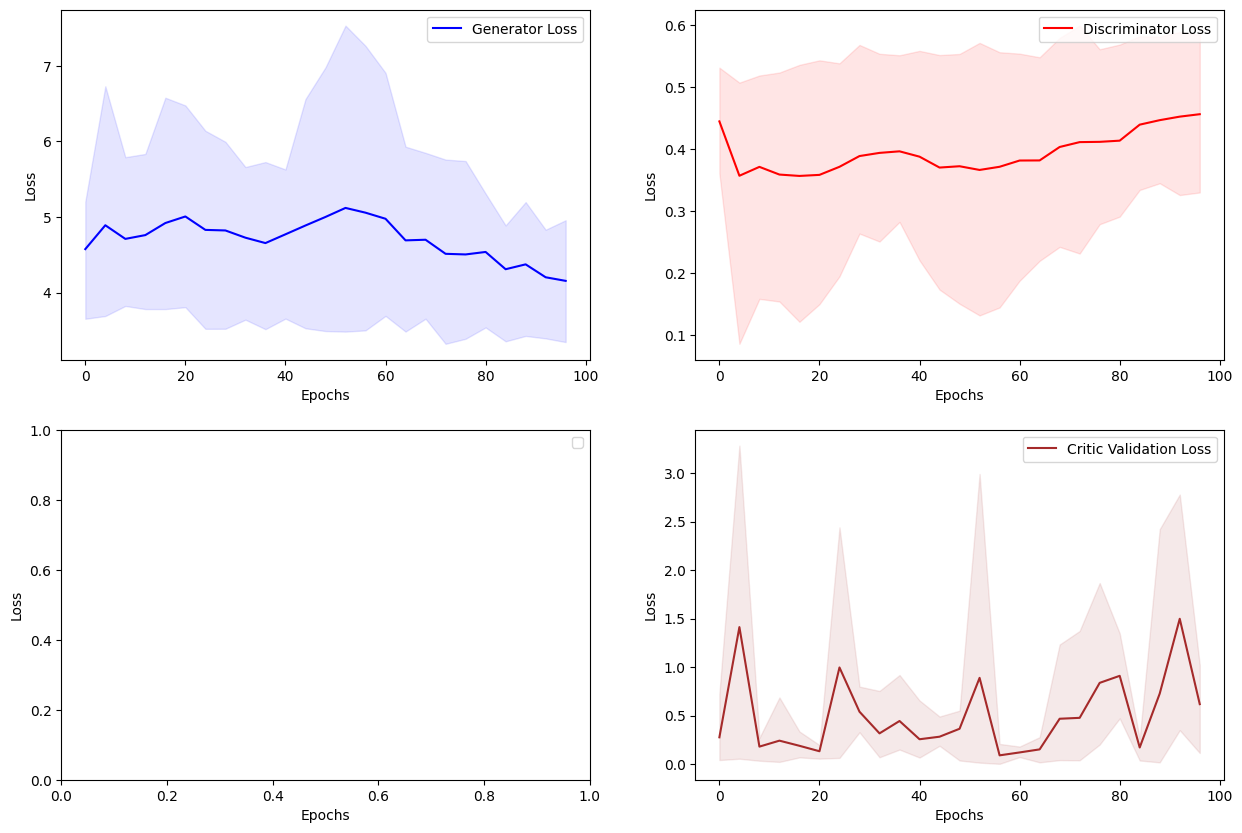

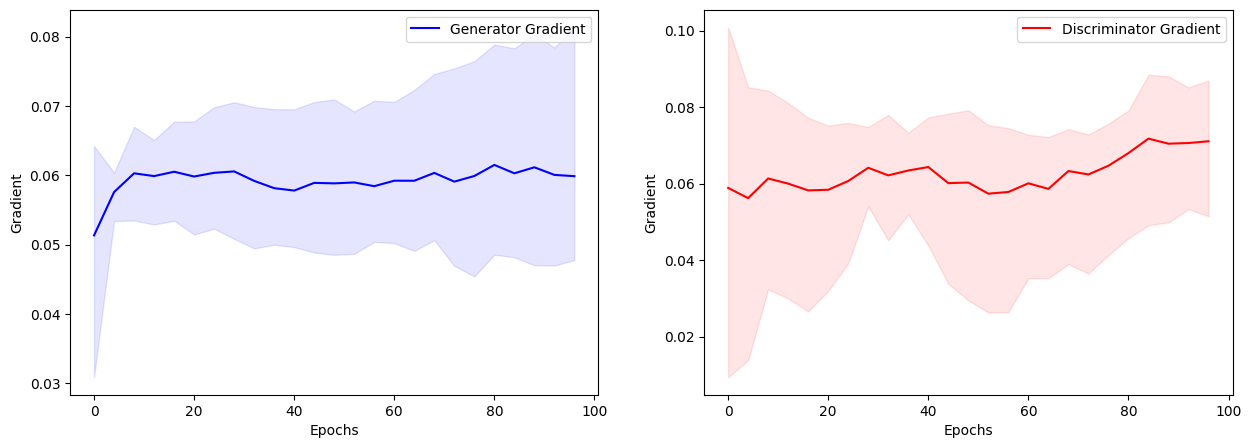

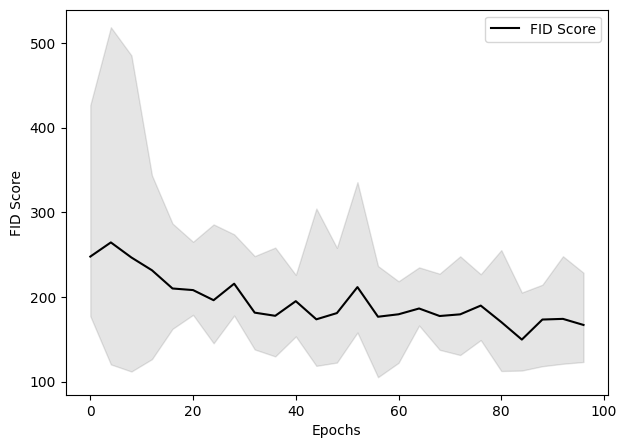

In [ ]:
num_splits = 4

# Function to split data
def split_data(data, num_intervals):
    split_size = len(data) // num_intervals
    return [data[i*split_size:(i+1)*split_size] for i in range(num_intervals)]

# Splitting the data
G_loss_splits = split_data(G_loss, num_splits)
C_loss_splits = split_data(C_loss, num_splits)
C_val_loss_splits = split_data(C_val_loss, num_splits)
G_grad_splits = split_data(G_grad, num_splits)
C_grad_splits = split_data(C_grad, num_splits)
FID_splits = split_data(FID, num_splits)

# Plotting function with shaded area
def plot_with_shades(ax, data, label, color):
    #epochs = range(len(data[0])) * num_splits
    epochs = [epoch * num_splits for epoch in range(num_epochs // num_splits)]
    means = np.mean(data, axis=0)
    minima = np.min(data, axis=0)
    maxima = np.max(data, axis=0)

    ax.plot(epochs, means, label=label, color=color)
    ax.fill_between(epochs, minima, maxima, color=color, alpha=0.1)

# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plotting
plot_with_shades(axs[0, 0], G_loss_splits, 'Generator Loss', 'blue')
plot_with_shades(axs[0, 1], C_loss_splits, 'Discriminator Loss', 'red')
plot_with_shades(axs[1, 1], C_val_loss_splits, 'Critic Validation Loss', 'brown')

fig, axg = plt.subplots(1, 2, figsize=(15, 5))
plot_with_shades(axg[0], G_grad_splits, 'Generator Gradient', 'blue')
plot_with_shades(axg[1], C_grad_splits, 'Discriminator Gradient', 'red')

# Plotting FID on its own figure because it often has a different scale
fig, ax_fid = plt.subplots(figsize=(7, 5))
plot_with_shades(ax_fid, FID_splits, 'FID Score', 'black')

# Adding labels and legends
for ax in axs.flat:
    ax.set(xlabel='Epochs', ylabel='Loss')
    ax.legend(loc='upper right')

for ax in axg.flat:
    ax.set(xlabel='Epochs', ylabel='Gradient')
    ax.legend(loc='upper right')

ax_fid.set(xlabel='Epochs', ylabel='FID Score')
ax_fid.legend(loc='upper right')

plt.show()

# Print sample images

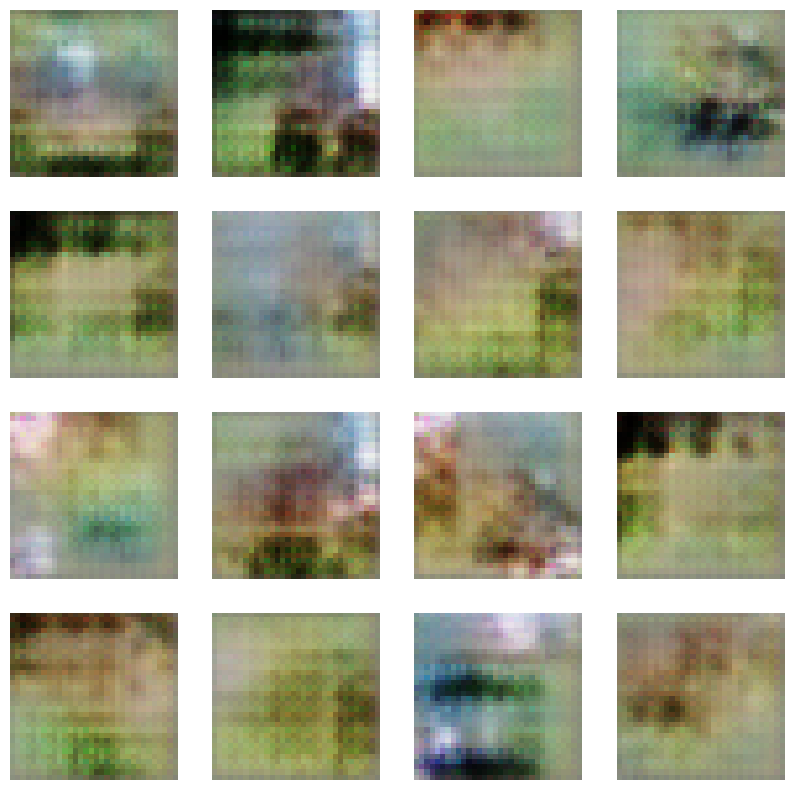

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to generate and show images
def show_generated_images(generator, num_images=25, z_dim=100):
    generator.eval()  # Set the generator to evaluation mode

    # Generate random noise
    noise = torch.randn(num_images, z_dim, device=device)

    # Generate images from the noise
    with torch.no_grad():  # No need to track gradients
        fake_images = generator(noise)

    # Move images to the CPU and convert to numpy arrays
    fake_images = fake_images.cpu().numpy()

    # Rescale images from [-1, 1] to [0, 1]
    fake_images = (fake_images + 1) / 2

    # Plot the images
    fig, axs = plt.subplots(sqrt_num_images, sqrt_num_images, figsize=(10, 10))
    idx = 0
    for i in range(sqrt_num_images):
        for j in range(sqrt_num_images):
            axs[i,j].imshow(np.transpose(fake_images[idx], (1, 2, 0)))
            axs[i,j].axis('off')
            idx += 1
    plt.show()

num_images = 16
sqrt_num_images = int(np.sqrt(num_images))  # Assuming num_images is a perfect square
show_generated_images(generator, num_images=sqrt_num_images**2, z_dim=z_dim)

In [ ]:
torch.save(generator.state_dict(), 'generator.pth')
torch.save(critic.state_dict(), 'critic.pth')